Epoch 1/100
6885/6885 [==============================] - 71s 10ms/step - loss: 0.6485 - val_loss: 0.5582
Epoch 2/100
6885/6885 [==============================] - 66s 10ms/step - loss: 0.5586 - val_loss: 0.5370
Epoch 3/100
6885/6885 [==============================] - 66s 10ms/step - loss: 0.5422 - val_loss: 0.5302
Epoch 4/100
6885/6885 [==============================] - 66s 10ms/step - loss: 0.5367 - val_loss: 0.5276
Epoch 5/100
6885/6885 [==============================] - 66s 10ms/step - loss: 0.5334 - val_loss: 0.5252
Epoch 6/100
6885/6885 [==============================] - 65s 10ms/step - loss: 0.5309 - val_loss: 0.5233
Epoch 7/100
6885/6885 [==============================] - 66s 10ms/step - loss: 0.5290 - val_loss: 0.5220
Epoch 8/100
6885/6885 [==============================] - 66s 10ms/step - loss: 0.5277 - val_loss: 0.5212
Epoch 9/100
6885/6885 [==============================] - 66s 10ms/step - loss: 0.5267 - val_loss: 0.5206
Epoch 10/100
6885/6885 [==============================]

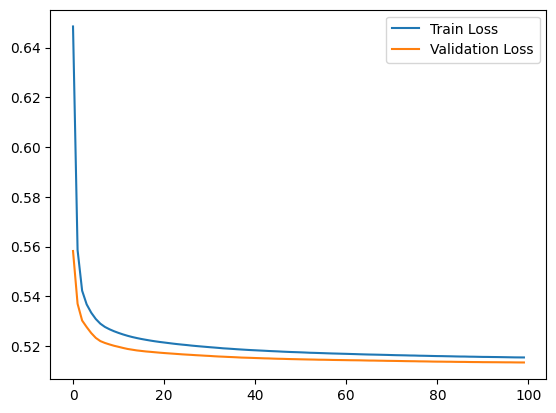

13893/13893 [==============================] - 39s 3ms/step
Best Threshold: 5.9142793351595655
Best F1 Score: 0.6504668691641354


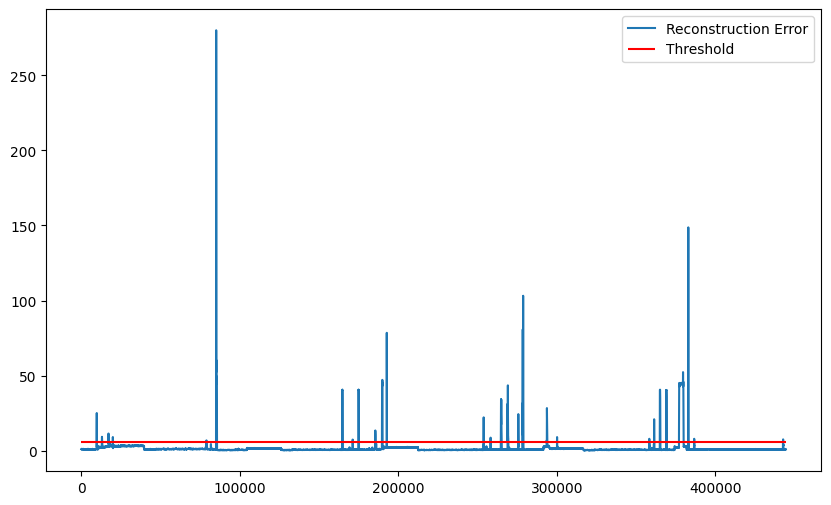

[[426557    467]
 [  8854   8673]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    427024
           1       0.95      0.49      0.65     17527

    accuracy                           0.98    444551
   macro avg       0.96      0.75      0.82    444551
weighted avg       0.98      0.98      0.98    444551



In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

# 데이터 읽기
TRAIN_FILES = sorted([x for x in Path("/content/drive/MyDrive/sj/train/").glob("*.csv")])
TEST_FILES = sorted([x for x in Path("/content/drive/MyDrive/sj/test/").glob("*.csv")])
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_FILES)
TEST_DF_RAW = dataframe_from_csvs(TEST_FILES)

# 공격 레이블 제거
ATTACK_DF = TEST_DF_RAW['attack']
DROP_FIELD = ["time", "attack_P1", "attack_P2", "attack_P3", "attack"]
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(DROP_FIELD)

# 데이터 정규화
scaler = StandardScaler()
TRAIN_DF = scaler.fit_transform(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])
TEST_DF = scaler.transform(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

# 슬라이딩 윈도우 함수 정의
def create_sliding_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)

# 윈도우 크기 설정
window_size = 50

# 슬라이딩 윈도우 적용
TRAIN_WINDOWS = create_sliding_windows(TRAIN_DF, window_size)
TEST_WINDOWS = create_sliding_windows(TEST_DF, window_size)

# 오토인코더 모델 정의 (모델 복잡도 증가)
input_dim = TRAIN_WINDOWS.shape[1] * TRAIN_WINDOWS.shape[2]
hidden_dim = 256
code_dim = 64

input_layer = Input(shape=(input_dim,))
hidden_1 = Dense(hidden_dim, activation='relu')(input_layer)
hidden_1 = Dropout(0.3)(hidden_1)  # Dropout 추가
code = Dense(code_dim, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_dim, activation='relu')(code)
hidden_2 = Dropout(0.3)(hidden_2)  # Dropout 추가
output_layer = Dense(input_dim, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.00001)  # 학습률 낮춤
autoencoder.compile(optimizer=optimizer, loss='mse')

# 데이터셋을 훈련 및 검증으로 분리
train_data, val_data = train_test_split(TRAIN_WINDOWS.reshape(-1, input_dim), test_size=0.2, random_state=42)

# 오토인코더 모델 훈련
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(train_data, train_data,
                          epochs=100,  # 에포크 증가
                          batch_size=64,  # 배치 사이즈 증가
                          shuffle=True,
                          validation_data=(val_data, val_data),
                          verbose=1,
                          callbacks=[early_stopping])

# 훈련 과정 시각화 (옵션)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 테스트 데이터셋 예측
TEST_WINDOWS_FLATTENED = TEST_WINDOWS.reshape(-1, input_dim)
reconstructed = autoencoder.predict(TEST_WINDOWS_FLATTENED)

# 재구성 오차 계산
mse = np.mean(np.power(TEST_WINDOWS_FLATTENED - reconstructed, 2), axis=1)

# 임계값 최적화 (F1 스코어 기준)
best_threshold = 0
best_f1 = 0

for threshold in np.linspace(np.min(mse), np.max(mse), 100):
    anomalies = mse > threshold
    anomalies = anomalies.astype(int)
    score = f1_score(ATTACK_DF.values[window_size // 2: -window_size // 2 + 1], anomalies)
    if score > best_f1:
        best_f1 = score
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1}')

# 최적 임계값으로 이상 탐지
anomalies = mse > best_threshold
anomalies = anomalies.astype(int)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(mse, label='Reconstruction Error')
plt.hlines(best_threshold, xmin=0, xmax=len(mse), colors='r', label='Threshold')
plt.legend()
plt.show()

# 공격 레이블과 비교
attack_labels = ATTACK_DF.values[window_size // 2: -window_size // 2 + 1]

print(confusion_matrix(attack_labels, anomalies))
print(classification_report(attack_labels, anomalies))